# Proposal: Factorization with long-range interations in anisotropically expanding domains

Let $V_1(\boldsymbol x)$ be a unit cell potential. Some examples might be
$$
\begin{aligned}
  V_1(\boldsymbol x) &= e^{-{\|\boldsymbol x\|}^2} \text{ (Gaussian)} \\
  V_1(\boldsymbol x) &= -\frac{1}{\|\boldsymbol x\|} \text{ (Coulomb, 3D)} \\
  V_1(\boldsymbol x) &= -\frac{1}{\|\boldsymbol x\|} e^{-\alpha \|\boldsymbol x\|} \text{ (Yukawa, 3D)} \\
  V_1(\boldsymbol x) &= -\log{\|\boldsymbol x\|} \text{ (Coulomb, 2D)} \\
  V_1(\boldsymbol x) &= -\log{\|\boldsymbol x\|} e^{-\alpha \|\boldsymbol x\|} \text{ (Yukawa, 2D)} \\
  V_1(\boldsymbol x) &= -\tfrac{1}{{\|\boldsymbol x\|}^3} \text{ (Dipole-dipole interaction, 3D) [1]} \\
\end{aligned}
$$
Then sum up the individual potentials to the total potential of an atom chain with $N$ atom to get (in 2D):
$$
V(\boldsymbol x) = \sum_{i=1}^N V_1\left(\boldsymbol x - {\left(i-\tfrac{1}{2},\tfrac{1}{2}\right)}^{\intercal}\right)
$$

## Considerations
- Be careful with the 2d case and log since it doesn't go to zero and thus adds up without weak convergence

## Ideas
- Call something *regularizer* when it yields $V(r(\boldsymbol{x})) \in L^{\infty}$
- Instead of the regularizer $r_1 : \mathbb R_+ \to \mathbb R_+ \setminus [0,\gamma), x \mapsto x + \gamma$ used in [StammTheisen '22], use $r_1 : \mathbb R_+ \to \mathbb R_+ \setminus [0,\varepsilon), x \mapsto \sqrt{x^2 + \epsilon^2}$ since it is smoother and is "closer" to real $|x|$ [https://rpubs.com/deleeuw/385443]

## Related material

- Definition and some examples of long-range* interactions: https://indico.ictp.it/event/7612/session/0/contribution/4/material/slides/0.pdf

## Refs
`[1]` https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Physical_Properties_of_Matter/Atomic_and_Molecular_Properties/Intermolecular_Forces/Specific_Interactions/Dipole-Dipole_Interactions

In [1]:
using PGFPlotsX
using LinearAlgebra
using LaTeXStrings
using Plots
using Latexify

In [2]:
function V(x :: Vector{Float64}, N :: Int64, Z :: Float64, alpha :: Float64, beta :: Float64, gamma :: Float64)
  return gamma + Z^2 * (
    -sum([
#                 1
#       exp(sum(-(x-[i-0.5,0.5]).^2))
      1/(norm(x-[i-0.5,0.5],2)+beta) * exp(- alpha * norm(x-[i-0.5,0.5],2))
#       -log(norm(x-[i,0],2)+beta) * exp(- alpha * norm(x-[i,0],2))
      # (norm(x-i,2)+beta) * exp(- alpha * (norm(x-i,2)+beta))
      # (norm(x-i,2)+beta)
      # 1/(norm(x-i,2)) * exp(- alpha * norm(x-i,2))
    for i=1:N])
  )
end

V (generic function with 1 method)

In [3]:
# Potential params => regulazied (β > 0) Yukawa (α > 0) potential with shift (γ ≠ 0)
α = 10^(-1)
β = 1E-2
γ = 10.
Z = 1.

1.0

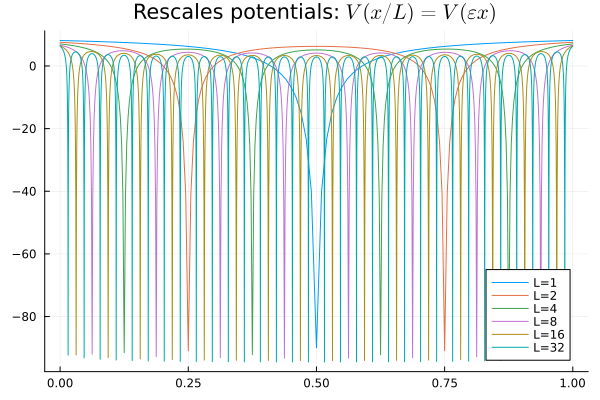

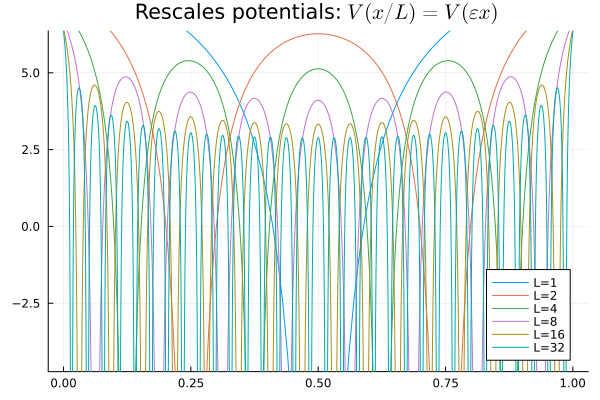

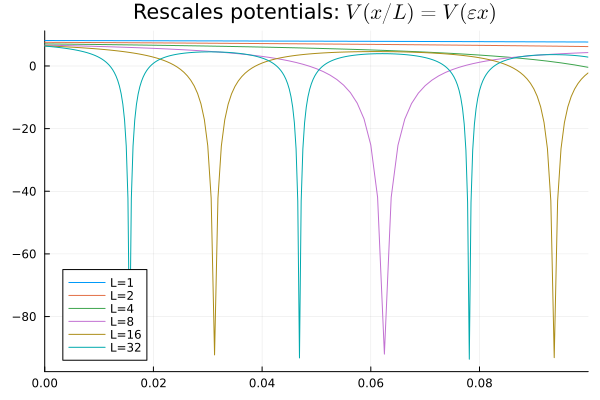

In [4]:
Lrange = [2^i for i=0:5]
yval = 0.5
p = plot()
for L in Lrange
    xrange = (0:0.01:L)/L
    coords = map(x -> [x,yval], xrange*L)
    plot!(xrange, V.(coords, L, Z, α, β, γ), labels="L=$(L)")
end
plot!(title="Rescales potentials: " * L"V(x/L) = V(\varepsilon x)")
display(p)
p1 = deepcopy(p)
plot!(p1, ylims=(findmin(p.series_list[end].plotattributes[:y])[1]/20, findmax(p.series_list[end].plotattributes[:y])[1]))
display(p1)
p2 = deepcopy(p)
plot!(p2, xlims=(0, 1/10))
display(p2)

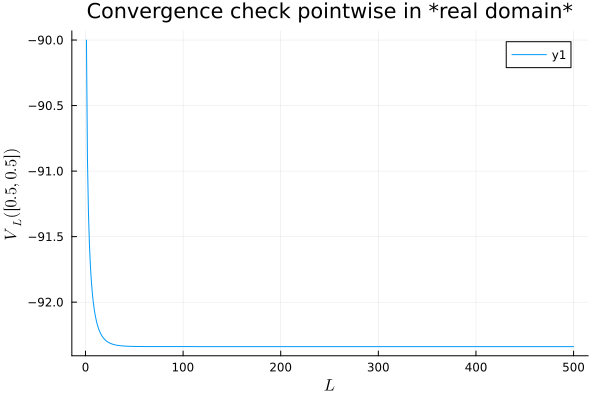

In [5]:
Lvec = 1:1:500
point = [0.5,0.5]
plot(Lvec, map(L -> V(point, L, Z, α, β, γ), Lvec))
plot!(
    title = "Convergence check pointwise in *real domain*",
    xlabel = L"L",
    ylabel = L"V_{L}(%$(point))",
)

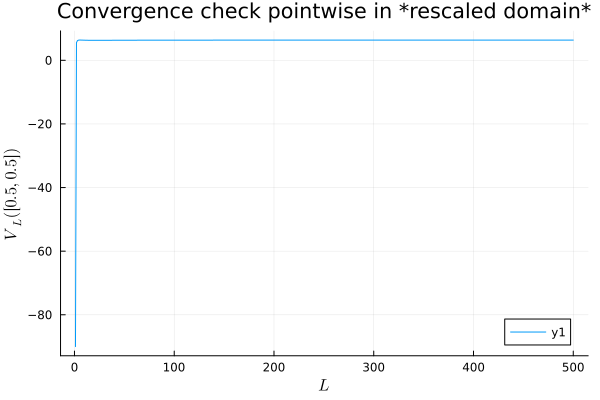

In [6]:
Lvec = 1:1:500
point = [0.5,0.5]
plot(Lvec, map(L -> V(point ./ [L,1], L, Z, α, β, γ), Lvec))
plot!(
    title = "Convergence check pointwise in *rescaled domain*",
    xlabel = L"L",
    ylabel = L"V_{L}(%$(point))",
)

## Theoretical approach for analysis

It's possible to interpret the potential $V$ in the following way:
$$
\begin{aligned}
V_L(x) &= V_{\infty}(x) + \Delta V(x) \\
&= V_{\infty}(x) + V_{\infty \setminus L}(x)
\end{aligned}
$$
Here, $V_{\infty}$ is the potential for an infinite amount of "particles" while $\Delta V(x)$ can be seen as the derivation from $V$ to $V_{\infty}$.

### Point-wise convergence

We observe that is the real space, the potential doesn't converge.

### Weak convergence 

When we rescale the domain to the reference domain $(0,1)$ (by applying $x \mapsto x/L$), we observe that $V_L(x/L)$ and $V_{\infty}(x/L)$ become more and more "aligned".

### Weak convergence of deviation to zero

To further formalize this observation, we plot the error between $e_L(x/L) := V_L(x/L) - V_{\infty}(x/L)$ and observe, that $e_L(x/L)$ weakly converges to zero. To only parts that do not strongly converge, are the $x$-boundary parts.

## Proof sketch

1. Factorize out the $V_{\infty}$ part as usual since it is periodic.
1. Rescale to unit cell and obtain:
    $$
    a_\varepsilon(u^{(m)}_\varepsilon,v) = \int_{\Omega_1} \rho_\varepsilon(\boldsymbol{x},\boldsymbol{y})
    \left( \frac{\partial u^{(m)}_\varepsilon}{\partial x_i} \frac{\partial v}{\partial x_i} + \frac{1}{\varepsilon^2} \frac{\partial u^{(m)}_\varepsilon}{\partial y_i} \frac{\partial v}{\partial y_i} + V_{\infty \setminus \tfrac{1}{\varepsilon}} u^{(m)}_\varepsilon v \right) d \boldsymbol{x} d \boldsymbol{y}
    $$
1. Boundes sequence in Banach space
1. Show that limit $u_0$ is $y$-independent
1. Apply oscillating test function and we have in (2.56) of [StammTheisen '22] two additional terms:
    1. One term with $\int \rho_{\varepsilon} V_{\infty \setminus \tfrac{1}{\varepsilon}} u^{(m)}_\varepsilon \varphi(x)  d z$. This vanishes in the limit since $u^{(m)}_\varepsilon$ is bounded, and $\varphi(x)$ doesn't depend on $\varepsilon$, $\rho_{\varepsilon}$ weakly converges to $\rho_0$ and $V_{\infty \setminus \tfrac{1}{\varepsilon}}$ weakly converges (to zero). Thus the whole expression comverges to the product of the weak limit and thus to zero.
    1. The other term is 
    $$
    \varepsilon \int_{\Omega_1} \rho_\varepsilon(\boldsymbol{x},\boldsymbol{y}) 
    \left\{
    \nabla u_\varepsilon
    \cdot
    \left(
      \sum_{i=1}^{p}
      \left(
        \frac{\partial}{\partial x_i}
        \begin{pmatrix} \nabla_{\boldsymbol{x}} \varphi(\boldsymbol{x}) \\ 0 \end{pmatrix}
        \theta_i(\tilde{\boldsymbol{x}},\boldsymbol{y})
      \right)
    \right)
    +
    \sum_{i=1}^{p}
        \frac{\partial \varphi(\boldsymbol{x})}{\partial x_i}
        \theta_i(\tilde{\boldsymbol{x}},\boldsymbol{y})
        V_{\infty \setminus \tfrac{1}{\varepsilon}}
    \right\}
    d \boldsymbol{x} d \boldsymbol{y}
    $$
    in which the $\sum_{i=1}^{p}\frac{\partial \varphi(\boldsymbol{x})}{\partial x_i}\theta_i(\tilde{\boldsymbol{x}},\boldsymbol{y})V_{\infty \setminus \tfrac{1}{\varepsilon}}$ is again bounded (even converges to zero) and the complete term thus vanishis in the product with $\varepsilon$.
1. Finish the homogenization procedure as usual..

**Thus, overall, the homogenization theorem yields the same asymptotic limit!** and thus the factorization approach still works in the numerics.

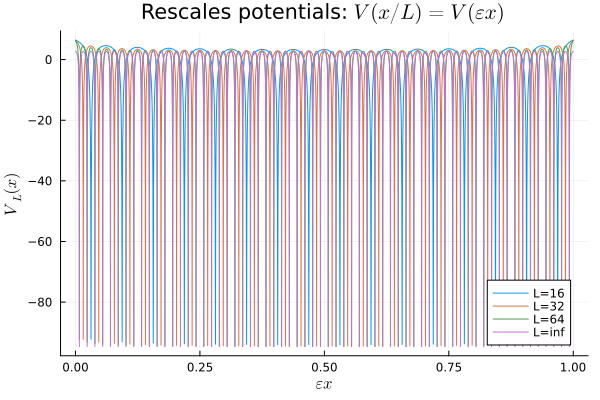

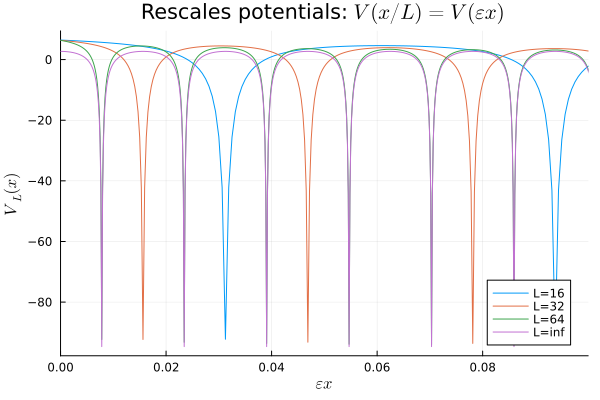

In [7]:
Linf = 2^10
Lrange = [2^i for i=4:6]
yval = 0.5
p = plot()
for L in Lrange
    xrange = (0:0.01:L)/L
    coords = map(x -> [x,yval], xrange*L)
    plot!(xrange, V.(coords, L, Z, α, β, γ), labels="L=$(L)", xlabel=L"\varepsilon x", ylabel=L"V_L(x)")
    # plot!(xrange, map(x->V([Linf÷2,x[2]] + [mod(x[1],1),0], Linf, Z, α, β, γ), coords), labels="L=$(L)")
    # plot!(xrange, V.(coords, L, Z, α, β, γ)-map(x->V([Linf÷2,x[2]] + [mod(x[1],1),0], Linf, Z, α, β, γ), coords), labels="L=$(L)")
end
plot!((0:0.01:Lrange[end])/Lrange[end], map(x->V([Linf÷2,x[2]] + [mod(x[1],1),0], Linf, Z, α, β, γ), map(x -> [x,yval], 0:0.01:Lrange[end])), labels="L=inf", alpha=1.0, linewidth=1)
plot!(title="Rescales potentials: " * L"V(x/L) = V(\varepsilon x)")
display(p)
p2 = deepcopy(p)
plot!(p2, xlims=(0, 1/10))
display(p2)

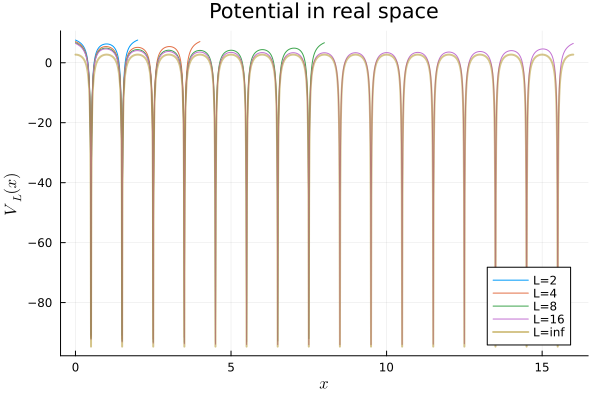

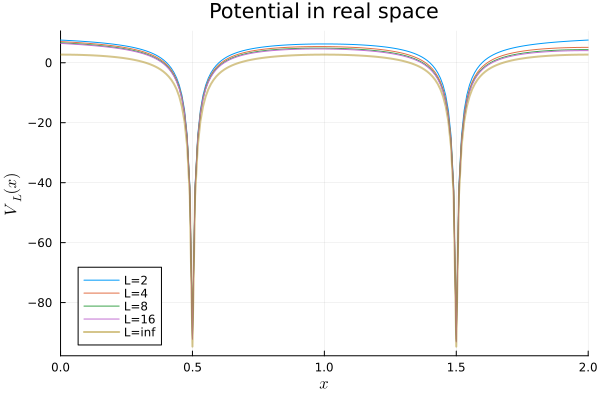

In [8]:
Linf = 2^10
Lrange = [2^i for i=1:4]
yval = 0.5
p = plot()
for L in Lrange
    xrange = (0:0.01:L)/L
    coords = map(x -> [x,yval], xrange*L)
    plot!(xrange*L, V.(coords, L, Z, α, β, γ), labels="L=$(L)", xlabel=L"x", ylabel=L"V_L(x)")
end
plot!((0:0.01:Lrange[end]), map(x->V([Linf÷2,x[2]] + [mod(x[1],1),0], Linf, Z, α, β, γ), map(x -> [x,yval], 0:0.01:Lrange[end])), labels="L=inf", alpha=0.5, linewidth=2, xlabel=L"x", ylabel=L"V_L(x)")
plot!(title="Potential in real space")
display(p)
p2 = deepcopy(p)
plot!(p2, xlims=(0, 2))
display(p2)

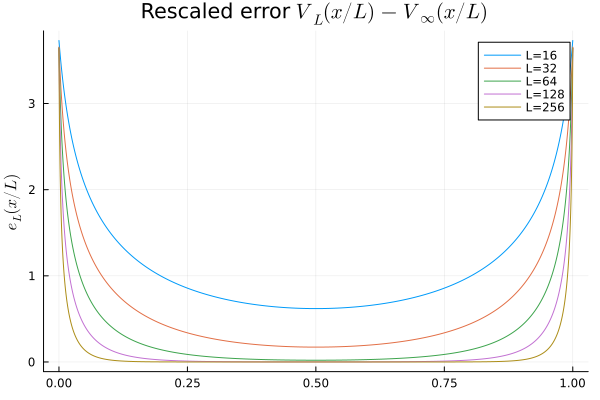

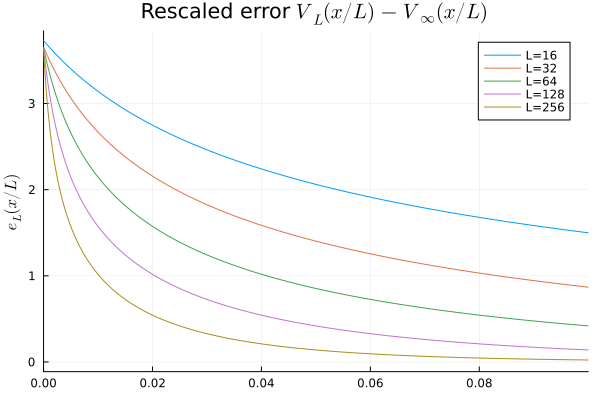

In [9]:
Linf = 2^10
Lrange = [2^i for i=4:8]
yval = 0.5
p = plot()
for L in Lrange
    xrange = (0:0.01:L)/L
    coords = map(x -> [x,yval], xrange*L)
    plot!(xrange, V.(coords, L, Z, α, β, γ)-map(x->V([Linf÷2,x[2]] + [mod(x[1],1),0], Linf, Z, α, β, γ), coords), labels="L=$(L)", ylabel=L"e_L(x/L)")
end
plot!(title="Rescaled error " * L"V_L(x/L) - V_{\infty}(x/L)")
display(p)
p2 = deepcopy(p)
plot!(p2, xlims=(0, 1/10))
display(p2)

## Numerical test

In [10]:
using Gridap
using LinearAlgebra
using SparseArrays
using LinearMaps
using ddEigenLab

ρ = 10
d = 2

2

In [11]:
Llimit = 500

Lxp = Lyp = 1
domain2 = ((Llimit ÷ 2 |> Float64) + 0.0, (Llimit ÷ 2 |> Float64) + 1.0, 0, Lyp)
partition2 = (Lxp * ρ, Lyp * ρ)
model2 = CartesianDiscreteModel(domain2, partition2; isperiodic=(true, false))
labels2 = get_face_labeling(model2)
add_tag_from_tags!(labels2, "diri", collect(1:3^2-1))
reffe2 = ReferenceFE(lagrangian, Float64, 1)
V02 = TestFESpace(model2, reffe2; conformity=:H1, dirichlet_tags = ["diri"])
Ug2 = TrialFESpace(V02, 0)
Ω2 = Triangulation(model2)
dΩ2 = Measure(Ω2, 2)

b2(v) = ∫( 1 * v ) * dΩ2
a11(u,v) = ∫( ∇(v) ⋅ ∇(u) + (x-> V([x.data...], Llimit, Z, α, β, γ)) * u * v ) * dΩ2
op11 = AffineFEOperator(a11, b2, Ug2, V02)
stiffnessmat2 = assemble_matrix(a11, Ug2, V02)
a22(u,v) = ∫( v * u ) * dΩ2
op22 = AffineFEOperator(a22, b2, Ug2, V02)
massmat2 = assemble_matrix(a22, Ug2, V02)

@info "start eigensolve periodic cell"
eigvec2, eigval2, errors, info = IP(stiffnessmat2, massmat2, 0, 1, 1, 1E-10, 1000)
@info "end eigensolve periodic cell"

uh2 = FEFunction(op11.trial, eigvec2);
writevtk(Ω2, "results_per", cellfields = ["uh2" => uh2])

modelnew = CartesianDiscreteModel(domain2, partition2)
Voutput2 = TestFESpace(modelnew, reffe2; conformity=:H1)
Vgrid2 = Gridap.FESpaces.interpolate(x-> V([x.data...], Llimit, Z, α, β, γ), Voutput2)
writevtk(Triangulation(modelnew), "potlim", cellfields = ["potlim" => Vgrid2])

[ Info: start eigensolve periodic cell


[001] λᵢ=10.9796 |eλ|₁=Inf |r|₂=3.03619E-01 |e|∞=1.56505E+00 |r|₁=2.43886E+00 |e|₂=1.00837E+01 |r|∞=5.34632E-02 |e|₁=9.06092E+01 
[002] λᵢ=10.8666 |eλ|₁=Inf |r|₂=3.25704E-02 |e|∞=1.63036E+00 |r|₁=2.75556E-01 |e|₂=1.00837E+01 |r|∞=6.10320E-03 |e|₁=8.95825E+01 
[003] λᵢ=10.8651 |eλ|₁=Inf |r|₂=4.04004E-03 |e|∞=1.64010E+00 |r|₁=3.34784E-02 |e|₂=1.00839E+01 |r|∞=9.20162E-04 |e|₁=8.94639E+01 
[004] λᵢ=10.8651 |eλ|₁=Inf |r|₂=5.93680E-04 |e|∞=1.64166E+00 |r|₁=4.75386E-03 |e|₂=1.00839E+01 |r|∞=1.48523E-04 |e|₁=8.94498E+01 
[005] λᵢ=10.8651 |eλ|₁=Inf |r|₂=1.05592E-04 |e|∞=1.64193E+00 |r|₁=8.33973E-04 |e|₂=1.00839E+01 |r|∞=2.60946E-05 |e|₁=8.94480E+01 
[006] λᵢ=10.8651 |eλ|₁=Inf |r|₂=2.10842E-05 |e|∞=1.64198E+00 |r|₁=1.68134E-04 |e|₂=1.00839E+01 |r|∞=4.92693E-06 |e|₁=8.94477E+01 
[007] λᵢ=10.8651 |eλ|₁=Inf |r|₂=4.39941E-06 |e|∞=1.64199E+00 |r|₁=3.52651E-05 |e|₂=1.00839E+01 |r|∞=9.77812E-07 |e|₁=8.94477E+01 
[008] λᵢ=10.8651 |eλ|₁=Inf |r|₂=9.30391E-07 |e|∞=1.64199E+00 |r|₁=7.50665E-06 |e|₂=1.00839

[ Info: end eigensolve periodic cell


(["potlim.vtu"],)

In [12]:
function execute(Lx)
    Ly = 1
    domain = nothing
    partition = nothing
    if d==2
      domain = (0, Lx, 0, Ly)
      partition = (Lx * ρ, Ly * ρ)
    elseif d==3
      @error "TODO: Not implemented"  
      domain = (0, Lx, 0, Ly, 0, Ly)
      partition = (Lx * ρ, Ly * ρ, Ly * ρ)
    else
      error("we need d=2,3")
    end
    model = CartesianDiscreteModel(domain, partition; isperiodic=(false, false))

    labels = get_face_labeling(model)
    add_tag_from_tags!(labels, "diri", collect(1:3^d-1))
    reffe = ReferenceFE(lagrangian, Float64, 1)
    V0 = TestFESpace(model, reffe; conformity=:H1, dirichlet_tags = ["diri"])
    Ug = TrialFESpace(V0, 0)
    Ω = Triangulation(model)
    dΩ = Measure(Ω,2)

    b(v) = ∫( 1 * v ) * dΩ  # dummy
    a1(u,v) = ∫( ∇(v) ⋅ ∇(u) + (x-> V([x.data...], Lx, Z, α, β, γ)) * u * v ) * dΩ
    op1 = AffineFEOperator(a1, b, Ug, V0)
    stiffnessmat = assemble_matrix(a1, Ug, V0)
    a2(u,v) = ∫( v * u ) * dΩ
    op2 = AffineFEOperator(a2, b, Ug, V0)
    massmat = assemble_matrix(a2, Ug, V0)

    σ = eigval2
    # σ = 0
    @time eigvec, eigval, errors, info = IP(stiffnessmat, massmat, σ, 1, 1, 1E-10, 1000, 1, zeros(size(massmat)[1]), false)
    # @time eigvec, eigval, errors, info = LOPCG(stiffnessmat, massmat, (stiffnessmat - σ * massmat), 1, 1, 1E-10, maxit, 1, xᵢ=x0)
    # @time eigvec, eigval, errors, info = SD(stiffnessmat, massmat, (stiffnessmat - σ * massmat), 1, 1, 1E-10, maxit, 1)

    writevtk(model, "model")
    uh = FEFunction(op1.trial, eigvec);
    writevtk(Ω, "results", cellfields = ["uh" => uh])

    Voutput = TestFESpace(model, reffe; conformity=:H1)
    Vgrid = Gridap.FESpaces.interpolate((x-> V([x.data...], Lx, Z, α, β, γ)), Voutput)
    writevtk(Ω, "pot", cellfields = ["pot" => Vgrid])

    plotErrors(errors, "Errors")
    @info "Needed $(length(errors)) its to converge for Lx=$(Lx)"
    return length(errors)
end

execute (generic function with 1 method)

In [13]:
Lxrange = [2^i for i=1:7]
itsarray = Int32[]
foreach(Lx -> push!(itsarray, execute(Lx)), Lxrange)

  0.304370 seconds (287.08 k allocations: 21.602 MiB, 99.47% compilation time)
  0.005110 seconds (1.03 k allocations: 5.753 MiB)
  0.012589 seconds (1.40 k allocations: 15.704 MiB)


[ Info: Needed 16 its to converge for Lx=2
[ Info: Needed 23 its to converge for Lx=4
[ Info: Needed 32 its to converge for Lx=8


  0.091111 seconds (1.57 k allocations: 35.120 MiB, 72.19% gc time)


[ Info: Needed 36 its to converge for Lx=16


  0.046705 seconds (1.52 k allocations: 55.932 MiB)


[ Info: Needed 28 its to converge for Lx=32


  0.063396 seconds (962 allocations: 72.150 MiB)


[ Info: Needed 17 its to converge for Lx=64


  0.094159 seconds (605 allocations: 93.589 MiB)


[ Info: Needed 10 its to converge for Lx=128


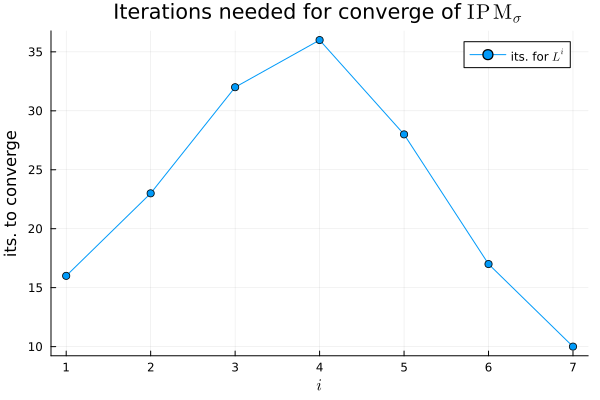

In [14]:
plot(itsarray, marker=:circle, title="Iterations needed for converge of " * L"\mathrm{IPM}_{\sigma}", xlabel=L"i", ylabel="its. to converge", labels="its. for "*L"L^i")